<h1> TP Adversarial Networks</h1>

Ce TP est consacré à la manipulation de réseaux génératifs exploitant le paradigme d'apprentissage "Adversarial". Ce type de réseaux comprend une partie "Générateur" et une autre "Discriminateur", chacun ayant des objectifs antagonistes.

La première partie de ce TP illustre la capacité des GAN sur des données artificielles, sous la forme d'un mélange de gaussiennes 1D. Cette partie est fortement guidée et met en évidence la capacité des deux sous réseaux pour parvenir à approcher au mieux la distribution sous jacentes des données.

La deuxième partie nécessite un travail en autonomie. Elle consiste à étendre le réseau préalablement définie pour, cette fois, modéliser la distribution des données issues du jeu de données MNIST (les chiffres manuscrits).

Pour finir, vous pourriez vous amuser et générer des visages réalistes à partir du jeu de données CelebA.

In [1]:
from tensorflow import keras
import keras.backend as K
import numpy as np



<h2>Partie 1: GANs avec des données artificielles</h2>

Dans la cellule suivante, on créé des données artificielles à partir de distributions gaussiennes. Par la suite, on modifiera le code pour obtenir des données multimodales (ie: mélange de gaussinnes).

In [ ]:
batch_size = 10
nbdata = 250
data_dim = 2 # 1-dimensional data

xdata = np.random.normal(5, 0.1, (nbdata, data_dim))
ydata = np.random.normal(10, 0.1, (nbdata, data_dim))

np.random.shuffle(xdata)
np.random.shuffle(ydata)



Affichage de la densité de distribution correspondant à nos données :

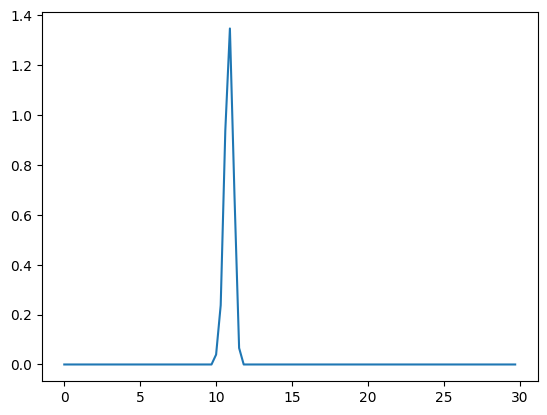

In [3]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

<h2>Création d'un générateur python pour accéder aux données par batch</h2>

In [4]:
def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if i+batch_size > nbdata: i = 0

    yield xdata[i:i+batch_size]

data_generator = get_batch()

# affiche un batch de données
x = next(data_generator)
print(x)

[[10.94138135]
 [10.93147959]
 [10.641554  ]
 [10.5130221 ]
 [10.46354414]
 [11.22148709]
 [11.03465021]
 [10.8708557 ]
 [10.88044579]
 [11.15899824]]


<h2> Création du réseau</h2>

Ici nous créons les deux parties : "générateur" et "discriminateur", puis le modèle combiné "GAN". Réseaux très simples comprenant deux couches cachées denses avec tanh + une couche sortie. Dropout dans le discriminateur.

In [5]:
# some hyperparameters
z_dim = 5
h_dim = 10

def generator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)/2), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)/2), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(data_dim))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

print(G.summary())

c:\Users\bausm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151 (604.00 B)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
def discriminator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(data_dim,)))
  model.add(keras.layers.Dense(int(h_dim/2), activation="tanh"))
  model.add(keras.layers.Dense(int(h_dim/2), activation="tanh"))
  model.add(keras.layers.Dropout(0.4))

  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

D = discriminator(opt)

print(D.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 10)             │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111 (444.00 B)

 Trainable params: 111 (444.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)
print(GAN.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 1)              │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 1)              │           111 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262 (1.02 KB)

 Trainable params: 151 (604.00 B)

 Non-trainable params: 111 (444.00 B)

None


<h2>Apprentissage du modèle</h2>

Initialisation de structures pour construire des plots

In [8]:
xtab = []
gtab = []
lossDtab = []
lossGtab = []
Dpostab = []
Dnegtab = []

epochs_done = 0

La boucle d'apprentissage alterne entre l'entrainement du discriminateur et du réseau composite "GAN".

Afin d'illustrer le fonctionnement de ce type de réseau, on enregistre les valeurs de loss du discriminateur (lossD) et du générateur (lossG), ainsi que les prédictions du discriminateur pour des exemples positifs (Dpos) et négatifs (Dneg). On conserve l'historique dans des listes pour affichage ultérieur. On enregistre aussi des données obtenues par le générateur à chaque epoch, ces données seront utilisées et animées dans une cellule suivante.

La conservation de ces différents éléments ralentit fortement l'entrainement. Attendez 3 minutes pour quelques exécutions puis commentez les instructions non nécessaires à l'entrainement du réseau.

In [14]:
import tensorflow as tf

data_generator = get_batch()
nb_epoch = 20 #2000
nb_batchs = int(nbdata/batch_size)
ones = np.ones((batch_size, 1))
zeros = np.zeros((batch_size, 1))
for epoch in range(nb_epoch):
  lossD = []
  lossG = []
  Dpos = []
  Dneg = []
  for batch in range(nb_batchs):

    # train discriminator with positive samples
    x = next(data_generator)
    lossP = D.train_on_batch(x, ones) # the discriminator must predict 1 for real samples

    if epoch % 10 == 0: # trace logits for plotting
      x = next(data_generator)
      Dpos.append( D.predict(x) )

    # train discriminator with negative samples
    z = tf.random.uniform(shape=(batch_size, z_dim), minval=-1, maxval=1)
    fakes = G.predict(z) # feed generator with random vectors to get fakes
    lossN = D.train_on_batch(fakes, zeros) # discriminator must predict 0 for fakes

    if epoch % 10 == 0: # trace logits for plotting
      z = tf.random.uniform(shape=(batch_size, z_dim), minval=-1, maxval=1)
      fakes = G.predict(z)
      Dneg.append( D.predict(fakes) )

    # compute D's loss (for plotting)
    lossD.append((lossP + lossN) / 2.)

    # train generator with GAN composite model
    z = np.random.uniform(-1, 1, (batch_size, z_dim))
    lossG.append( GAN.train_on_batch(z, ones) ) # must predict 1

  # Compute and store statistics for further plotting
  if epoch % 10 == 0:
    lossD = np.mean(lossD)
    lossG = np.mean(lossG)
    Dpos = np.mean(Dpos)
    Dneg = np.mean(Dneg)

    lossDtab.append(lossD)
    lossGtab.append(lossG)
    Dpostab.append(Dpos)
    Dnegtab.append(Dneg)

    print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )

  # Sample data from generator to plot an animation of learned distribution
  z = np.random.uniform(-1, 1, (10*batch_size, z_dim))
  g = G.predict(z)
  hg,_ = np.histogram(g, bins=bins, density=True)
  gtab.append(hg)
  xtab.append(hx)

  epochs_done = epochs_done + 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

<h2>Création et affichage des plots</h2>


<b>1. Evolution des prédictions du discriminateur sur les données réelles (en bleu) ou sur les données fournies par le générateur (en vert).</b>
On observe une convergence rapide vers 0.5, le point d'équilibre lorsque le discriminateur ne sait plus distinguer l'origine des données.

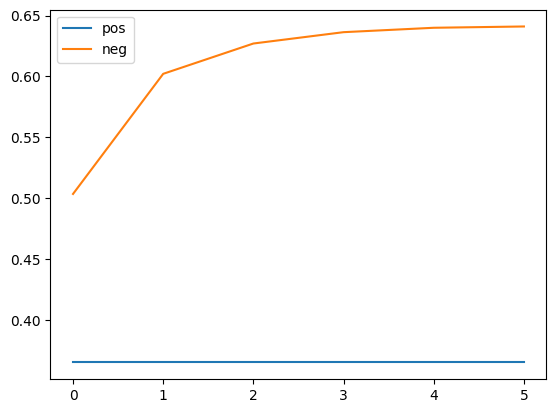

In [15]:
ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

<b>2. Evolution des données obtenues au cours de l'apprentissage.</b>
Selon le nombre d'epochs, la cellule suivante prend un peu de temps pour construire un gif que nous affichons dans la foulée. Cette étape nécessite l'installation du package ffmeg-python.

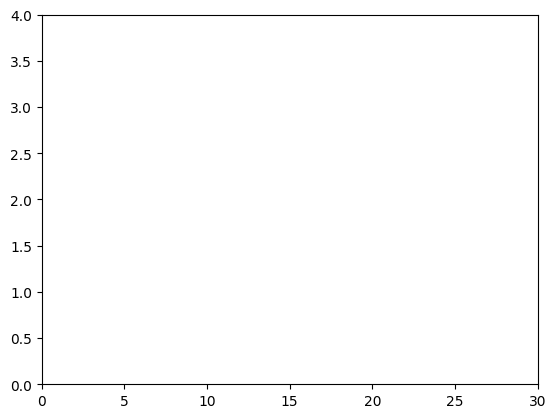

In [16]:
#!pip install ffmpeg-python

import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=False)
rc('animation', html='jshtml')
anim


<b>3. Comparaison entre un batch de données original et de données issues du générateur.</b>

some real data: [[10.94138135]
 [10.93147959]
 [10.641554  ]
 [10.5130221 ]
 [10.46354414]
 [11.22148709]
 [11.03465021]
 [10.8708557 ]
 [10.88044579]
 [11.15899824]]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
some generated data [[-6.9360948]
 [-6.937735 ]
 [-6.9371214]
 [-6.934281 ]
 [-6.936894 ]
 [-6.938469 ]
 [-6.938793 ]
 [-6.9379396]
 [-6.9388347]
 [-6.936974 ]]


c:\Users\bausm\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


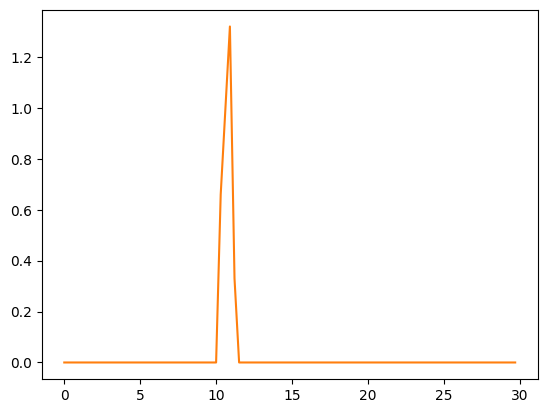

In [17]:
# get a batch of real data (for comparison)
x = next(data_generator)
print("some real data:", x)

# sample some noise then transform them with our generator
z = np.random.uniform(-1,1,(10*batch_size, z_dim))
g = G.predict(z)
print("some generated data", g[:10])

# plot distributions
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)

hg,_ = np.histogram(g, bins=bins, density=True)
plt.plot(xs,hg)

hx,_ = np.histogram(x, bins=bins, density=True)
plt.plot(xs,hx)
plt.show()

# Travail à faire

1. Modifiez la première fonction de création de données pour obtenir la moitiée de données centrées autour de 5 et l'autre autour de 10. La distribution de probabilité associée à ces données est dite "multimodale" (2 modes).

2. Réinitialisez les modèles et relancez l'apprentissage. Essayez plus d'epoch si besoin.

3. Augmentez les capacités du discriminateur et générateur en augmentant leur nombre de neurones dans les couches cachées.

4. Augmentez de nouveau le nombre de modes de la distribution de données et retentez l'expérience. La difficulté de parvenir à apprendre des distributions multimodales correspond au "mode collapse" dans la littérature GAN. Une manière de contourner ce problème consiste à encourager le discriminateur à reconnaitre une diversité dans un batch d'exemples. Plusieurs approches ont été proposées dans ce sens, dont "batch discrimination" et "standard deviation discrimination" (à voir dans la littérature).

<h2>Partie 2: Adversarial Autoencoder sur Fashion-MNIST</h2>

https://keras.io/api/datasets/fashion_mnist/

Cette partie se déroule en totale autonomie. Une fois bien compris la partie précédente, proposez un réseau autoencoder pour générer des images de vêtements en 28x28 pixels (et/ou des visages pour les très motivés).

Plutôt que de suivre l'approche variationnelle VAE, implémentez la variante avec contrainte adversariale AAE où un discriminateur contraint l'encodeur pour qu'il produise des vecteurs similaires à des tirages d'une distribution a priori (ie: Normale ou Uniforme).

Pour le jeu de données Fashion MNIST, les réseaux pourront exploiter des couches Dense, Conv2D, MaxPooling2D et UpSampling2D. L'espace latent intermédiaire ne devrait pas dépasser 10) 20 neurones pour encoder la variabilité des formes du jeu de données.

